In [17]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Helper function for score aggregation
def aggregate_classes(score):
    if score < 55:
        return "Below 55"
    elif score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

In [19]:
# Load and preprocess data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [20]:
# Apply SMOTE for balanced dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [22]:
# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1]
}

In [23]:
# Initialize and train SVM with GridSearchCV
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['rbf', 'linear']},
             scoring='f1_weighted')

In [24]:
# Get best model and make predictions
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print("\nFinal Model Performance (SVM):")
print(classification_report(y_test, y_pred))
print(f"Final Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Final Model Performance (SVM):
              precision    recall  f1-score   support

       55-60       0.99      1.00      1.00       656
       61-65       0.95      0.94      0.95       733
       66-70       0.93      0.90      0.91       635
       71-75       0.96      0.98      0.97       664
       76-80       1.00      1.00      1.00       715
         81+       0.99      1.00      1.00       669

    accuracy                           0.97      4072
   macro avg       0.97      0.97      0.97      4072
weighted avg       0.97      0.97      0.97      4072

Final Test Set Accuracy: 0.9715


In [28]:
def plot_class_distribution():
    plt.figure(figsize=(15, 5))
    
    # Before SMOTE
    plt.subplot(1, 2, 1)
    initial_distribution = y.value_counts().sort_index()
    plt.bar(initial_distribution.index, initial_distribution.values)
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # After SMOTE
    plt.subplot(1, 2, 2)
    balanced_distribution = pd.Series(y_balanced).value_counts().sort_index()
    plt.bar(balanced_distribution.index, balanced_distribution.values)
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix():
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_decision_boundary():
    # Use PCA to reduce features to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_balanced)
    
    # Create label encoder for target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_balanced)
    
    # Train SVM on PCA-transformed data
    svm_pca = SVC(kernel='rbf', random_state=42)
    svm_pca.fit(X_pca, y_encoded)
    
    # Create mesh grid
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Plot decision boundary
    plt.figure(figsize=(12, 8))
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis')
    
    # Create custom legend
    legend_labels = [f"{i}: {label}" for i, label in enumerate(le.classes_)]
    plt.colorbar(scatter, label='Score Range', 
                ticks=range(len(le.classes_)))
    
    plt.title('SVM Decision Boundaries (PCA-reduced features)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.tight_layout()
    plt.show()

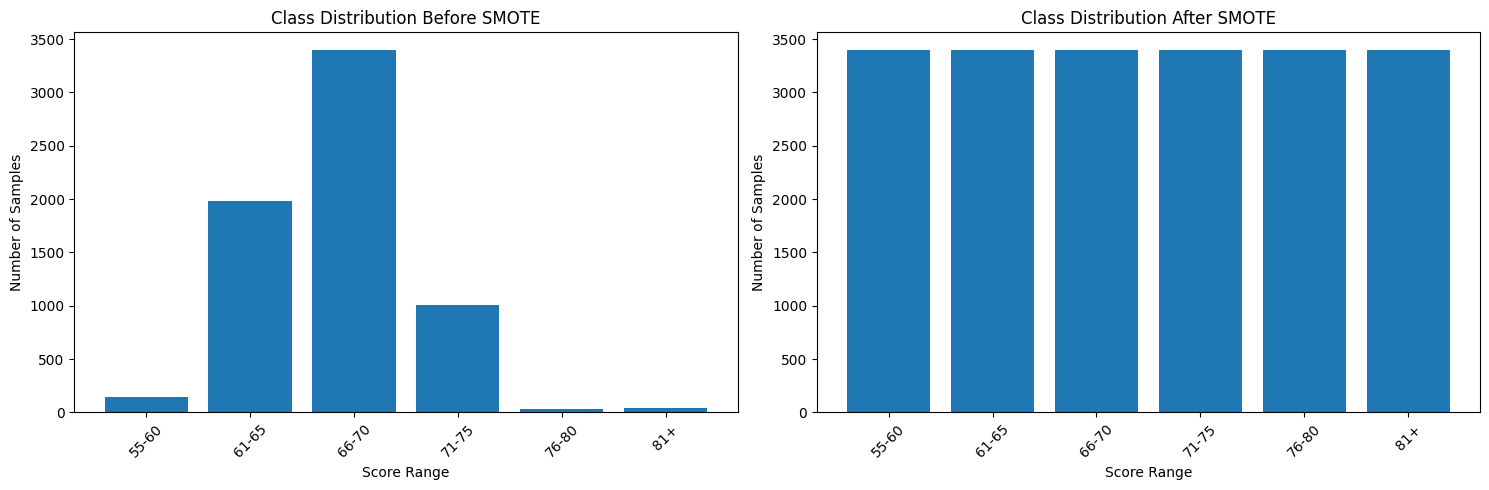

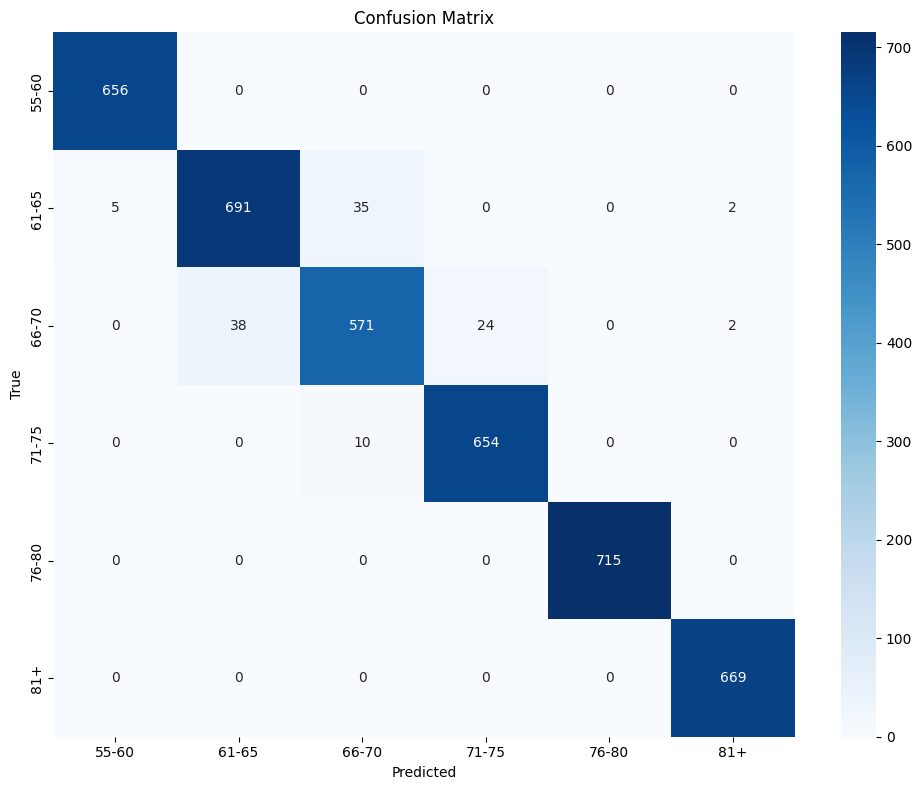

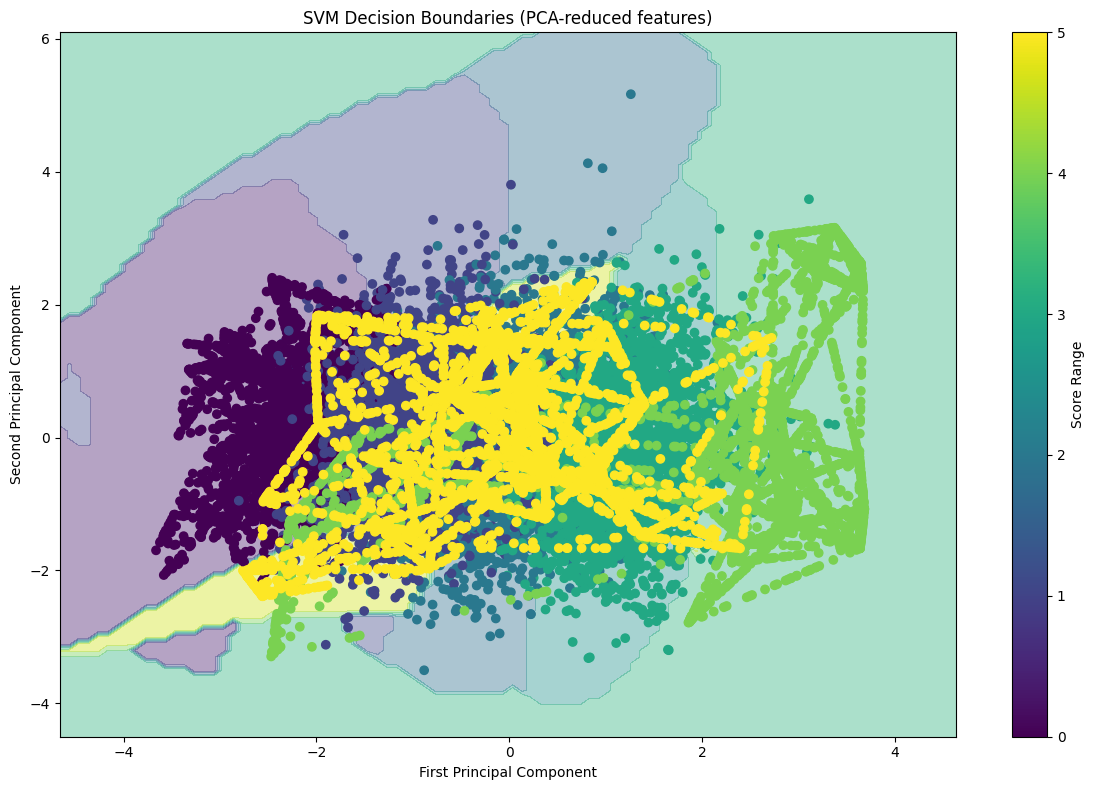

In [29]:
# Generate plots
plot_class_distribution()
plot_confusion_matrix()
plot_decision_boundary()